In [1]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

from models.kangru import KANGRU
from utils.stock_data import get_log_return_loaders, StockIndex
from utils.early_stopping import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


## NVDA ##

In [2]:
stock = StockIndex.NVDA
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=48
)
input_dim = next(iter(train_dl))[0].shape[-1]

In [3]:
model = KANGRU(
    input_dim=input_dim,
    hidden_dim=64,
    num_layers=2,
    output_dim=1,
    device=device,
    grid=13,
    k=2,
)

# best params taken from the tuning process

# --- Train ---
model.fit(train_dl, val_dl=val_dl, steps=40,
          patience=15,
          lr=0.006606998028725651,
          lamb=0.0008251731794814873,
          lamb_entropy = 0.24267972801572674,
          lamb_l1 = 1.311260552687473,
          lamb_coef = 2.9275528404866757e-05,
          lamb_coefdiff = 1.6257343048503087e-05
         )

Step 19 | MSE: 1.13e-03 | Reg: 2.45e+01 | Total: 2.13e-02 | Val MSE: 7.31e-04:  50%|▌| 20/40 [01:19<01:19,  3.

Early stopping at step 20


Mean predicted return: -0.001637
Std of predicted return: 0.000270
Mean actual return: 0.002644
Std of actual return: 0.032575
RMSE (price): 3.8885
MAE (price): 3.0348


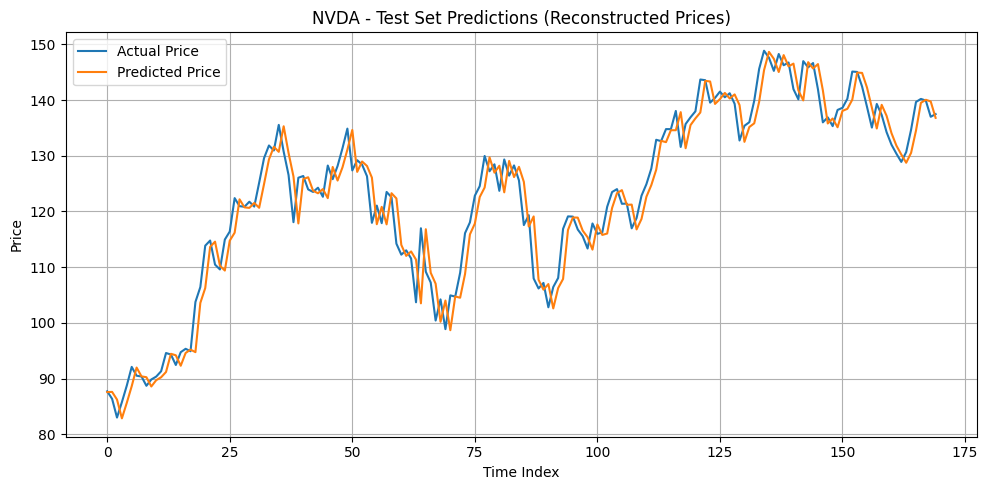

LaTeX Table Row:
KANGRU & NVDA & -0.001637 & 0.000270 & 0.002644 & 0.032575 & 3.8885 & 3.0348 \\


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
model.eval()
preds, targets, prev_prices = [], [], []

# Run inference
with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(model.device)
        y_pred = model(xb).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct prices from log returns
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

# Compute metrics
rmse = np.sqrt(np.mean((pred_prices - true_prices) ** 2))
mae = np.mean(np.abs(pred_prices - true_prices))
mean_pred = np.mean(preds)
std_pred = np.std(preds)
mean_actual = np.mean(targets)
std_actual = np.std(targets)

# Print results
print(f"Mean predicted return: {mean_pred:.6f}")
print(f"Std of predicted return: {std_pred:.6f}")
print(f"Mean actual return: {mean_actual:.6f}")
print(f"Std of actual return: {std_actual:.6f}")
print(f"RMSE (price): {rmse:.4f}")
print(f"MAE (price): {mae:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(true_prices, label='Actual Price')
plt.plot(pred_prices, label='Predicted Price')
plt.title(f"{stock.value} - Test Set Predictions (Reconstructed Prices)")
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# LaTeX table row (copy-paste directly into your LaTeX file)
print("LaTeX Table Row:")
print(f"KANGRU & NVDA & {mean_pred:.6f} & {std_pred:.6f} & {mean_actual:.6f} & {std_actual:.6f} & {rmse:.4f} & {mae:.4f} \\\\")


## AAPL ##

In [11]:
stock = StockIndex.AAPL
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=32
)
input_dim = next(iter(train_dl))[0].shape[-1]

In [6]:
model_aapl = KANGRU(
    input_dim=input_dim,
    hidden_dim=16,
    num_layers=1,
    output_dim=1,
    device=device,
    grid=16,
    k=4,
)

# best params taken from the tuning process

# --- Train ---
model_aapl.fit(train_dl, val_dl=val_dl, steps=40,
          patience=15,
          lr=0.0009833181933644897,
          lamb=1.4843697010415788e-05,
          lamb_entropy = 0.6908664112597581,
          lamb_l1 = 0.7178483118508193,
          lamb_coef = 0.0015446089075047066,
          lamb_coefdiff = 0.0008178476574339542,
         )

Step 29 | MSE: 2.75e-04 | Reg: 4.17e+00 | Total: 3.37e-04 | Val MSE: 1.83e-04:  75%|▊| 30/40 [01:40<00:33,  3.

Early stopping at step 30


Mean predicted return: 0.000317
Std of predicted return: 0.002507
Mean actual return: 0.002366
Std of actual return: 0.014482
RMSE (price): 3.1590
MAE (price): 2.3550


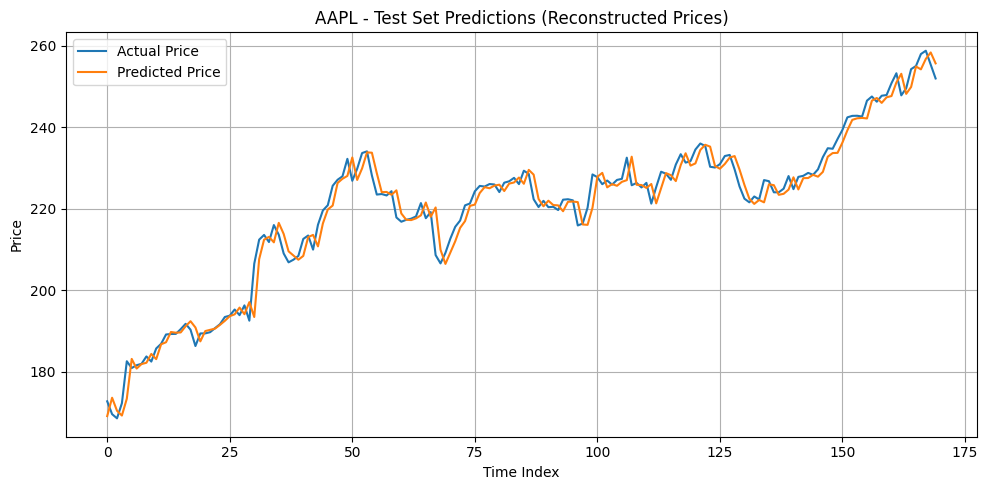

LaTeX Table Row:
KANGRU & AAPL & 0.000317 & 0.002507 & 0.002366 & 0.014482 & 3.1590 & 2.3550 \\


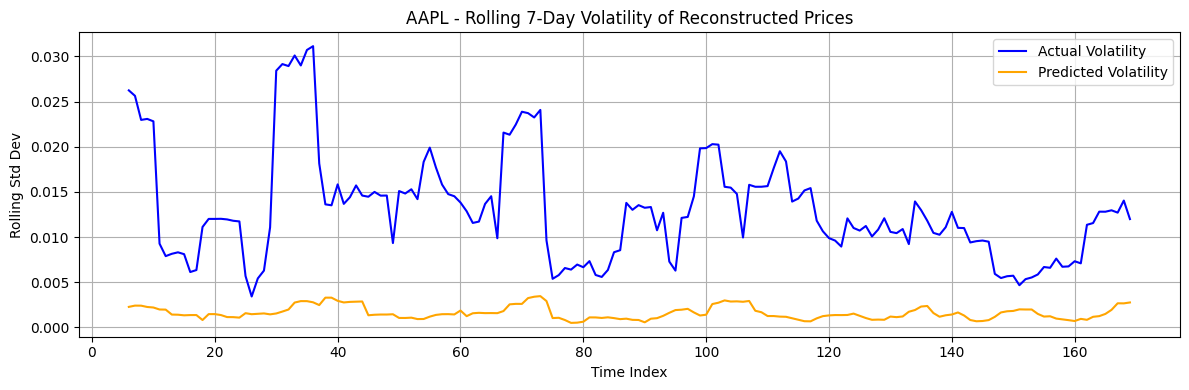

In [15]:
# Set model to evaluation mode
model_aapl.eval()
preds, targets, prev_prices = [], [], []

# Run inference
with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(model_aapl.device)
        y_pred = model_aapl(xb).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct prices from log returns
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

# Compute metrics
rmse = np.sqrt(np.mean((pred_prices - true_prices) ** 2))
mae = np.mean(np.abs(pred_prices - true_prices))
mean_pred = np.mean(preds)
std_pred = np.std(preds)
mean_actual = np.mean(targets)
std_actual = np.std(targets)

# Print results
print(f"Mean predicted return: {mean_pred:.6f}")
print(f"Std of predicted return: {std_pred:.6f}")
print(f"Mean actual return: {mean_actual:.6f}")
print(f"Std of actual return: {std_actual:.6f}")
print(f"RMSE (price): {rmse:.4f}")
print(f"MAE (price): {mae:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(true_prices, label='Actual Price')
plt.plot(pred_prices, label='Predicted Price')
plt.title(f"{stock.value} - Test Set Predictions (Reconstructed Prices)")
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("kangru_preds.png")
plt.show()

# LaTeX table row (copy-paste directly into your LaTeX file)
print("LaTeX Table Row:")
print(f"KANGRU & AAPL & {mean_pred:.6f} & {std_pred:.6f} & {mean_actual:.6f} & {std_actual:.6f} & {rmse:.4f} & {mae:.4f} \\\\")

import pandas as pd
# --- Rolling Volatility (Price Level) ---
def rolling_std(x, window=7):
    return pd.Series(x).rolling(window=window).std().to_numpy()

window = 7# can tweak
rolling_true_vol = rolling_std(targets, window)
rolling_pred_vol = rolling_std(preds, window)

# --- Plot Volatility ---
plt.figure(figsize=(12, 4))
plt.plot(rolling_true_vol, label="Actual Volatility", color="blue")
plt.plot(rolling_pred_vol, label="Predicted Volatility", color="orange")
plt.title(f"{stock.value} - Rolling {window}-Day Volatility of Reconstructed Prices")
plt.xlabel("Time Index")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## KO ##

In [16]:
stock = StockIndex.KO
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=64
)
input_dim = next(iter(train_dl))[0].shape[-1]

In [9]:
model_ko = KANGRU(
    input_dim=input_dim,
    hidden_dim=112,
    num_layers=1,
    output_dim=1,
    device=device,
    grid=5,
    k=3,
)

# best params taken from the tuning process

# --- Train ---
model_ko.fit(train_dl, val_dl=val_dl, steps=40,
          patience=25,
          lr=0.0010177741207291712,
          lamb=4.185092346381734e-05,
          lamb_entropy = 1.5812984977636078,
          lamb_l1 = 1.535546579048181,
          lamb_coef = 2.91941013100606e-05,
          lamb_coefdiff = 0.0058096631325982254,
         )

Step 39 | MSE: 1.12e-04 | Reg: 5.61e+01 | Total: 2.46e-03 | Val MSE: 9.50e-05: 100%|█| 40/40 [01:55<00:00,  2.


Mean predicted return: 0.004420
Std of predicted return: 0.002445
Mean actual return: 0.000158
Std of actual return: 0.008269
RMSE (price): 0.6272
MAE (price): 0.4876


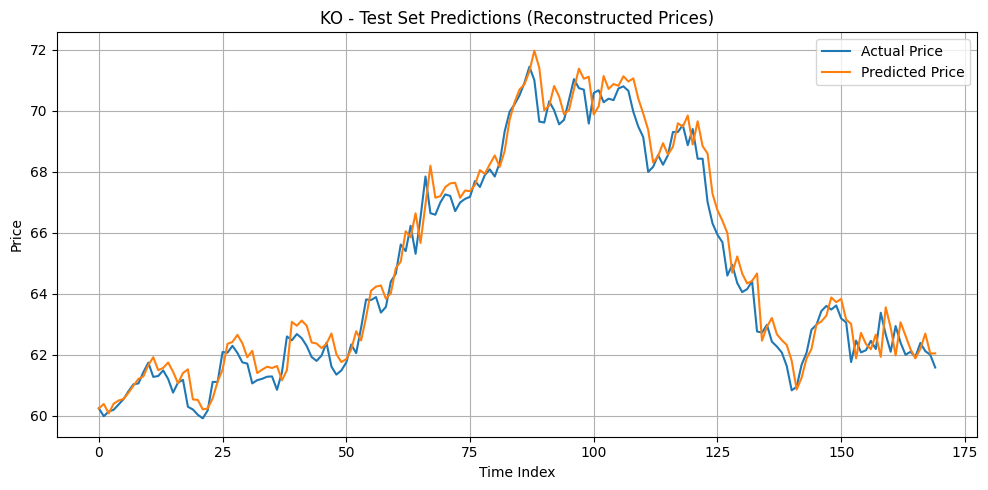

LaTeX Table Row:
KANGRU & KO & 0.004420 & 0.002445 & 0.000158 & 0.008269 & 0.6272 & 0.4876 \\


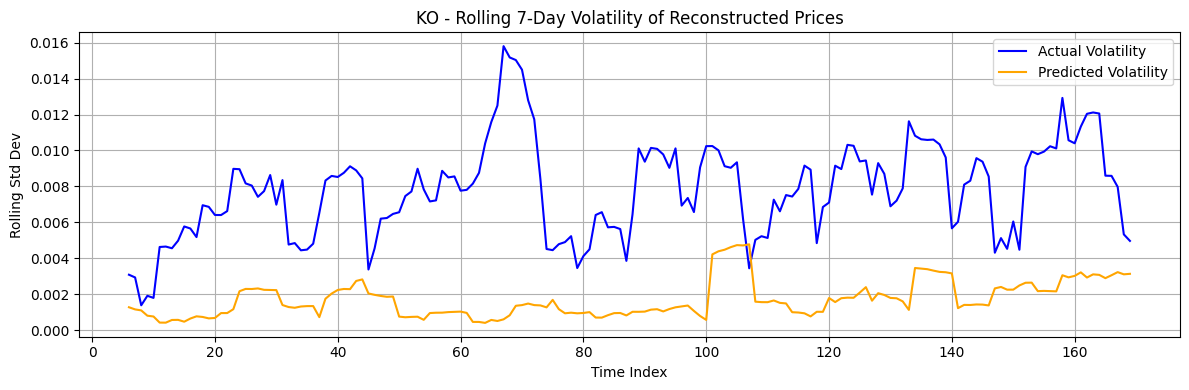

In [17]:
# Set model to evaluation mode
model_ko.eval()
preds, targets, prev_prices = [], [], []

# Run inference
with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(model_ko.device)
        y_pred = model_ko(xb).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct prices from log returns
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

# Compute metrics
rmse = np.sqrt(np.mean((pred_prices - true_prices) ** 2))
mae = np.mean(np.abs(pred_prices - true_prices))
mean_pred = np.mean(preds)
std_pred = np.std(preds)
mean_actual = np.mean(targets)
std_actual = np.std(targets)

# Print results
print(f"Mean predicted return: {mean_pred:.6f}")
print(f"Std of predicted return: {std_pred:.6f}")
print(f"Mean actual return: {mean_actual:.6f}")
print(f"Std of actual return: {std_actual:.6f}")
print(f"RMSE (price): {rmse:.4f}")
print(f"MAE (price): {mae:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(true_prices, label='Actual Price')
plt.plot(pred_prices, label='Predicted Price')
plt.title(f"{stock.value} - Test Set Predictions (Reconstructed Prices)")
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("kangru_preds.png")
plt.show()

# LaTeX table row (copy-paste directly into your LaTeX file)
print("LaTeX Table Row:")
print(f"KANGRU & KO & {mean_pred:.6f} & {std_pred:.6f} & {mean_actual:.6f} & {std_actual:.6f} & {rmse:.4f} & {mae:.4f} \\\\")

import pandas as pd
# --- Rolling Volatility (Price Level) ---
def rolling_std(x, window=7):
    return pd.Series(x).rolling(window=window).std().to_numpy()

window = 7  # can tweak
rolling_true_vol = rolling_std(targets, window)
rolling_pred_vol = rolling_std(preds, window)

# --- Plot Volatility ---
plt.figure(figsize=(12, 4))
plt.plot(rolling_true_vol, label="Actual Volatility", color="blue")
plt.plot(rolling_pred_vol, label="Predicted Volatility", color="orange")
plt.title(f"{stock.value} - Rolling {window}-Day Volatility of Reconstructed Prices")
plt.xlabel("Time Index")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

